# Text classification with transformer model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_transformer_text_classification.ipynb)

In this short tutorial, we will perform sentiment analysis on movie reviews. We would like
to know if a review is overall positive or negative, so we're facing a classification task.

For that purpose, we're going to build a model comprised of a transformer and dense layers.
What is special about transformers is that they utilize an attention mechanism that allows
the model to focus on the most relevant parts of the input sequence when processing information.

We will follow the standard ML model-building process - split data into training and test sets,
construct the model, run training, and report metrics.

In [1]:
# Required packages
# !pip install -U jax flax optax
# !pip install -U grain tqdm requests matplotlib

## Tools overview

Here's a list of key packages we will use in this example that belong to JAX AI stack:

- [JAX](https://github.com/jax-ml/jax) will be used for array computations.
- [Flax](https://github.com/google/flax) for constructing neural networks.
- [Optax](https://github.com/google-deepmind/optax) for gradient processing and optimization.
- [grain](https://github.com/google/grain/) will be be used to define data sources.
- [tqdm](https://tqdm.github.io/) for a progress bar to monitor the training progress.

In [2]:
import io
import json
import textwrap
import typing

import jax
import jax.numpy as jnp
from flax import nnx
import optax
import grain.python as grain
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import requests

## Dataset

We're going to use [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/).
Each review is encoded as a list of word indexes, where words are indexed by
the frequency. The label is a positive or negative sentiment (0 or 1).

In [3]:
def prepare_imdb_dataset(num_words: int, index_from: int, oov_char: int = 2) -> tuple:
    response = requests.get("https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz")
    response.raise_for_status()
    with np.load(io.BytesIO(response.content), allow_pickle=True) as f:
        x_train, y_train = f["x_train"], f["y_train"]
        x_test, y_test = f["x_test"], f["y_test"]

    rng = np.random.RandomState(113)
    indices = np.arange(len(x_train))
    rng.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    indices = np.arange(len(x_test))
    rng.shuffle(indices)
    x_test = x_test[indices]
    y_test = y_test[indices]

    x_train = [[w + index_from for w in x] for x in x_train]
    x_test = [[w + index_from for w in x] for x in x_test]

    xs = x_train + x_test
    labels = np.concatenate([y_train, y_test])
    xs = [
        [w if w < num_words else oov_char for w in x] for x in xs
    ]

    idx = len(x_train)
    x_train, y_train = np.array(xs[:idx], dtype="object"), labels[:idx]
    x_test, y_test = np.array(xs[idx:], dtype="object"), labels[idx:]

    return (x_train, y_train), (x_test, y_test)


def pad_sequences(arrs: typing.Iterable, max_len: int) -> np.ndarray:
    # Ensure that each sample is the same length
    result = []
    for arr in arrs:
        arr_len = len(arr)
        if arr_len < max_len:
            padded_arr = np.pad(arr, (max_len - arr_len, 0), 'constant', constant_values=0)
        else:
            padded_arr = np.array(arr[arr_len - max_len:])
        result.append(padded_arr)

    return np.asarray(result)

In [4]:
index_from = 3  # make sure that 0 encodes pad token
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_test, y_test) = prepare_imdb_dataset(num_words=vocab_size, index_from=index_from)
print(len(x_train), "Training sequences")
print(len(x_test), "Validation sequences")
x_train = pad_sequences(x_train, max_len=maxlen)
x_test = pad_sequences(x_test, max_len=maxlen)

25000 Training sequences
25000 Validation sequences


For handling input data we're going to use Grain, a pure Python package developed for JAX and
Flax models. Grain supports custom setups where data sources might come in different forms, but
they all need to implement the `grain.RandomAccessDataSource` interface. See
[PyGrain Data Sources](https://github.com/google/grain/blob/main/docs/source/data_sources.md)
for more details.

Our dataset is comprised of relatively small NumPy arrays so our `DataSource` is uncomplicated:

In [5]:
class DataSource(grain.RandomAccessDataSource):
    def __init__(self, x, y):
        self._x = x
        self._y = y

    def __getitem__(self, idx):
        return {"encoded_indices": self._x[idx], "label": self._y[idx]}

    def __len__(self):
        return len(self._x)

In [6]:
train_source = DataSource(x_train, y_train)
test_source = DataSource(x_test, y_test)

In [7]:
seed = 12
train_batch_size = 128
test_batch_size = 2 * train_batch_size

train_sampler = grain.IndexSampler(
    len(train_source),
    shuffle=True,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)

test_sampler = grain.IndexSampler(
    len(test_source),
    shuffle=False,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)


train_loader = grain.DataLoader(
    data_source=train_source,
    sampler=train_sampler,  # Sampler to determine how to access the data
    worker_count=4,         # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,   # Count of output batches to produce in advance per worker
    operations=[
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

test_loader = grain.DataLoader(
    data_source=test_source,
    sampler=test_sampler,  # Sampler to determine how to access the data
    worker_count=4,        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,  # Count of output batches to produce in advance per worker
    operations=[
        grain.Batch(test_batch_size),
    ]
)

## Model

Here we construct the model with the transformer and dense layers:

In [8]:
class TransformerBlock(nnx.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, rngs: nnx.Rngs, rate: float = 0.1):
        self.attention = nnx.MultiHeadAttention(
            num_heads=num_heads, in_features=embed_dim, qkv_features=embed_dim, decode=False, rngs=rngs
        )

        self.dense_1 = nnx.Linear(in_features=embed_dim, out_features=ff_dim, rngs=rngs)
        self.dense_2 = nnx.Linear(in_features=ff_dim, out_features=ff_dim, rngs=rngs)

        self.layer_norm_1 = nnx.LayerNorm(num_features=embed_dim, epsilon=1e-6, rngs=rngs)
        self.layer_norm_2 = nnx.LayerNorm(num_features=ff_dim, epsilon=1e-6, rngs=rngs)

        self.dropout_1 = nnx.Dropout(rate, rngs=rngs)
        self.dropout_2 = nnx.Dropout(rate, rngs=rngs)

    def __call__(self, inputs: jax.Array):
        x = self.attention(inputs, inputs)
        x = self.dropout_1(x)
        x_norm_1 = self.layer_norm_1(inputs + x)
        x = self.dense_1(x_norm_1)
        x = jax.nn.relu(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        x = self.layer_norm_2(x_norm_1 + x)
        return x

In [9]:
class TokenAndPositionEmbedding(nnx.Module):
    def __init__(self, max_length: int, vocab_size: int, embed_dim: int, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=max_length, features=embed_dim, rngs=rngs)

    def __call__(self, x: jax.Array):
        maxlen = jnp.shape(x)[-1]
        positions = jnp.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [10]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in the feed forward network inside transformer

class MyModel(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, rngs=rngs)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rngs=rngs)
        self.dropout1 = nnx.Dropout(0.1, rngs=rngs)
        self.dense1 = nnx.Linear(in_features=embed_dim, out_features=20, rngs=rngs)
        self.dropout2 = nnx.Dropout(0.1, rngs=rngs)
        self.dense2 = nnx.Linear(in_features=20, out_features=2, rngs=rngs)

    def __call__(self, x: jax.Array):
        x = self.embedding_layer(x)
        x = self.transformer_block(x)
        x = jnp.mean(x, axis=(1,))  # global average pooling
        x = self.dropout1(x)
        x = self.dense1(x)
        x = jax.nn.relu(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        x = jax.nn.softmax(x)
        return x

In [11]:
model = MyModel(rngs=nnx.Rngs(0))
nnx.display(model)

MyModel(
  embedding_layer=TokenAndPositionEmbedding(
    token_emb=Embed(
      embedding=Param(
        value=Array(shape=(20000, 32), dtype=float32)
      ),
      num_embeddings=20000,
      features=32,
      dtype=dtype('float32'),
      param_dtype=<class 'jax.numpy.float32'>,
      embedding_init=<function variance_scaling.<locals>.init at 0x7f0cab141e10>
    ),
    pos_emb=Embed(
      embedding=Param(
        value=Array(shape=(200, 32), dtype=float32)
      ),
      num_embeddings=200,
      features=32,
      dtype=dtype('float32'),
      param_dtype=<class 'jax.numpy.float32'>,
      embedding_init=<function variance_scaling.<locals>.init at 0x7f0cab141e10>
    )
  ),
  transformer_block=TransformerBlock(
    attention=MultiHeadAttention(
      num_heads=2,
      in_features=32,
      qkv_features=32,
      out_features=32,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      broadcast_dropout=True,
      dropout_rate=0.0,
      deterministic=None,
      

## Training

To train our model we construct an `nnx.Optimizer` object with our model and a selected
optimization algorithm. We're going to use Adam optimizer, which is a popular choice for
Deep Learning models. Adam automatically adjusts the learning rate for each parameter and
uses momentum hyperparameter to accelerate convergence.

In [12]:
num_epochs = 10
learning_rate = 0.0001
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adam(learning_rate, momentum))

In [13]:
def compute_losses_and_logits(model: nnx.Module, batch_tokens: jax.Array, labels: jax.Array):
    logits = model(batch_tokens)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels
    ).mean()
    return loss, logits

In [14]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, jax.Array]
):
    batch_tokens = jnp.array(batch["encoded_indices"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch_tokens, labels)

    optimizer.update(grads)  # In-place updates.

    return loss

@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, jax.Array], eval_metrics: nnx.MultiMetric
):
    batch_tokens = jnp.array(batch["encoded_indices"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)
    loss, logits = compute_losses_and_logits(model, batch_tokens, labels)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

In [15]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

In [16]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(x_train) // train_batch_size

def train_one_epoch(epoch):
    model.train()
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()

    eval_metrics.reset()  # Reset the eval metrics
    for test_batch in test_loader:
        eval_step(model, test_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

In [17]:
%%time
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/10, [192/195], loss=0.693 [00:36<00:00]


[test] epoch: 1/10
- total loss: 0.6879
- Accuracy: 0.5661


[train] epoch: 1/10, [192/195], loss=0.678 [00:35<00:00]


[test] epoch: 2/10
- total loss: 0.6734
- Accuracy: 0.6507


[train] epoch: 2/10, [192/195], loss=0.594 [00:35<00:00]


[test] epoch: 3/10
- total loss: 0.6177
- Accuracy: 0.7316


[train] epoch: 3/10, [192/195], loss=0.511 [00:35<00:00]


[test] epoch: 4/10
- total loss: 0.5404
- Accuracy: 0.7890


[train] epoch: 4/10, [192/195], loss=0.466 [00:35<00:00]


[test] epoch: 5/10
- total loss: 0.4995
- Accuracy: 0.8159


[train] epoch: 5/10, [192/195], loss=0.463 [00:35<00:00]


[test] epoch: 6/10
- total loss: 0.4806
- Accuracy: 0.8280


[train] epoch: 6/10, [192/195], loss=0.435 [00:35<00:00]


[test] epoch: 7/10
- total loss: 0.4714
- Accuracy: 0.8349


[train] epoch: 7/10, [192/195], loss=0.421 [00:35<00:00]


[test] epoch: 8/10
- total loss: 0.4665
- Accuracy: 0.8394


[train] epoch: 8/10, [192/195], loss=0.409 [00:35<00:00]


[test] epoch: 9/10
- total loss: 0.4602
- Accuracy: 0.8453


[train] epoch: 9/10, [192/195], loss=0.389 [00:35<00:00]


[test] epoch: 10/10
- total loss: 0.4560
- Accuracy: 0.8486
CPU times: user 27min 44s, sys: 12min 14s, total: 39min 59s
Wall time: 8min 19s


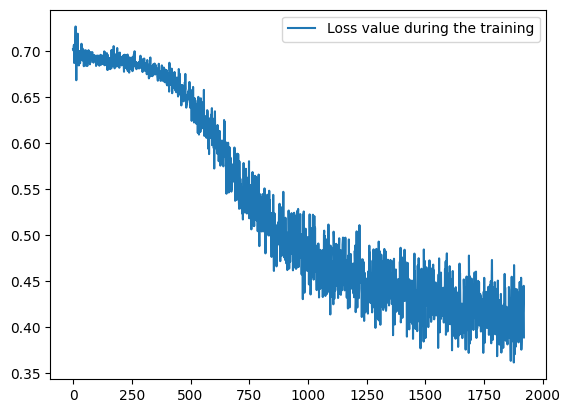

In [18]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

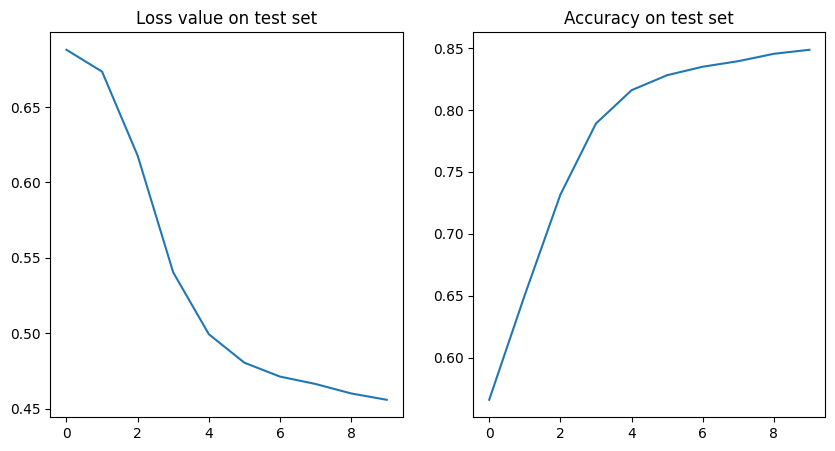

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Loss value on test set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on test set")
axs[1].plot(eval_metrics_history["test_accuracy"])

As we can see, we acquired over 85% accuracy on a sentiment classification problem
after 10 epochs. From the loss plot, we see that in the last few epochs the loss
value didn't improve much which is an indication that our model has converged.

JAX AI stack allowed us to build, train, and evaluate the model with JAX ecosystem
libraries that interoperate smoothly in a multitude of computing environments.

Let's now inspect a few predictions ourselves. First we're going to download
"indices to words" dictionary to decode our samples. Then we will decode a few samples
and print them together with a prediced and an actual label.

In [20]:
response = requests.get("https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb_word_index.json")
response.raise_for_status()
word_map = {v: k for k, v in json.loads(response.content).items()}

In [21]:
def _label_to_str(label: int) -> str:
    return "positive" if label else "negative"

def show_reviews(indices: list[int]) -> None:
    for idx in indices:
        x = x_test[idx][x_test[idx] != 0]
        y = y_test[idx]
        y_pred = model(x_test[idx][None, :]).argmax()
        review = ""
        for w_x in x:
            idx = w_x - index_from if w_x >= index_from else w_x
            review += f"{word_map[idx]} "

        print("Review:")
        for line in textwrap.wrap(review):
            print(line)
        print("Predicted sentiment: ", _label_to_str(y_pred))
        print("Actual sentiment: ", _label_to_str(y), "\n")

In [22]:
show_reviews([0, 500, 600, 1000, 1800, 2000])

Review:
please give this one a miss br br kristy swanson and the rest of the
cast rendered terrible performances the show is flat flat flat br br i
don't know how michael madison could have allowed this one on his
plate he almost seemed to know this wasn't going to work out and his
performance was quite lacklustre so all you madison fans give this a
miss
Predicted sentiment:  negative
Actual sentiment:  negative 

Review:
this is a funny movie the bob eddie show feel of it could lead to a
sequel but i doubt it will make enough money br br deniro proves he
can be a great straight man again with some hilarious and spontaneous
moments eddie was fun to watch working with people instead of cgi
animals and and rene russo well she's just fun to watch anyway and
she's played her part excellent br br some wild and unusual stunts
especially the garbage truck scene this was worth seeing in the
theater we needed a good laugh and got many from the movie and the
great out takes at the end do not lea